Test pour voir si mon push est passé. bis

Notebook inspiré sur de nombreux points par l'article suivant https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

idéalement le notebook en tant que tel sans avoir à associer d'autres trucs. Il importe le dataset etc.

In [153]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [154]:
#df1=pd.read_csv("https://www.cryptodatadownload.com/cdd/HitBTC_BTCUSD_d.csv", sep=",")
#df1.tail()

In [155]:
df=pd.read_csv("./Data/HitBTC_ETHUSD_1h.csv", sep=",")
df = df.rename(columns={'Close': 'value'})
new=df['value']
new=pd.DataFrame({'value':new.values})
print(new[0:8])

    value
0  534.73
1  533.85
2  532.83
3  524.71
4  519.44
5  528.51
6  510.56
7  519.92


# Génération de features

Mise en forme séquentielle des données. Le but des cellules à venir est d'arriver à un jeu de la forme (batch,timesteps,features). Dans notre cas batch sera l'intégralité des individus du dataset, timesteps sera 100 (cf input dim), ie on va prédire à t+1 basé sur t, t-1,...,t-99 ; et on aura une feature : le prix de la crypto.

In [156]:
def generate_dataset(df, nb_timesteps):
    df_n=df.copy()
    for k in range(1,nb_timesteps): #à chaque ité on ajoute une colonne
        df_n[f"t-{k}"]=df_n["value"].shift(k)
    df_n=(df_n[nb_timesteps-1:][:])
    cols=(df_n.columns.to_list())[::-1]
    df_n=df_n[cols]
    return df_n

input_dim = 100

df_generated = generate_dataset(new, input_dim)
df_generated

,t-99,t-98,t-97,t-96,t-95,t-94,t-93,t-92,t-91,t-90,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,value
99,534.73,533.85,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,...,608.18,610.00,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36
100,533.85,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,...,610.00,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50
101,532.83,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,...,608.87,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40
102,524.71,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,565.28,...,609.69,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40,606.73
103,519.44,528.51,510.56,519.92,528.24,542.16,536.90,540.16,565.28,569.04,...,607.31,610.17,610.64,614.42,612.48,613.36,614.50,606.40,606.73,606.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,307.48,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,...,297.10,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62
5429,307.60,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,...,297.81,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98
5430,306.41,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,...,296.56,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17
5431,304.86,304.77,305.11,304.40,305.82,305.83,305.45,306.11,305.54,307.40,...,296.20,296.89,295.13,297.56,297.13,295.18,295.62,293.98,295.17,294.34


# Feature engineering

Pour quand t'auras le temps bg

# Jeux d'entrainement et test

Très important ici : on deal avec des données séquentielles, il faut donc surtout pas shuffle au moment de la création des jeux de données. L'ordre doit rester le même.

In [157]:
output_timesteps=10 #nombre de prédictions faites à la suite. Time step of the output.
batch_size = 64
n_epochs = 10

In [158]:
def feature_label_split(df, target_cols):
    y = df[target_cols] #la variable à fitter est la première, on aura donc target col = value
    X = df.drop(columns=target_cols)
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))
    X_scaled=scalerX.fit_transform(X)
    y_scaled=scalerY.fit_transform(y)
    return X_scaled, y_scaled, scalerX, scalerY

def train_val_test_split(df, target_cols, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y, scalerX, scalerY = feature_label_split(df, target_cols)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    print(y_test.shape)
    return X_train, X_val, X_test, y_train, y_val, y_test, scalerX, scalerY


cols=df_generated.columns.to_list()
cols=cols[len(cols)-output_timesteps:]
X_train, X_val, X_test, y_train, y_val, y_test, scalerX, scalerY = train_val_test_split(df_generated, cols, 0.2)

(1067, 10)


Ici on prend qu'une colonne à fitter. Gênant pour ensuite générer des séquences prédites plus longues?

# RNN

Pour entrainer un modèle tensorflow il est préférable d'avoir des données du type tensor.

In [159]:
X_train=tf.convert_to_tensor(X_train)
X_train=tf.reshape(X_train,shape=(X_train.shape[0],X_train.shape[1],1))

X_val=tf.convert_to_tensor(X_val)
X_val=tf.reshape(X_val,shape=(X_val.shape[0],X_val.shape[1],1))

X_test=tf.convert_to_tensor(X_test)
X_test=tf.reshape(X_test,shape=(X_test.shape[0],X_test.shape[1],1))

y_train=tf.convert_to_tensor(y_train)
y_train=tf.reshape(y_train,shape=(y_train.shape[0],y_train.shape[1],1))

y_val=tf.convert_to_tensor(y_val)
y_val=tf.reshape(y_val,shape=(y_val.shape[0],y_val.shape[1],1))

y_test=tf.convert_to_tensor(y_test)
y_test=tf.reshape(y_test,shape=(y_test.shape[0],y_test.shape[1],1))

In [160]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(3200, 90, 1) (1067, 90, 1) (1067, 90, 1) (3200, 10, 1) (1067, 10, 1) (1067, 10, 1)


units (# de neurones) n'a pas besoin d'être de la même longueur que la séquence.

In [161]:
model = keras.Sequential()
model.add(layers.SimpleRNN(32, input_shape=(X_train.shape[1],1), return_sequences=True))
model.add(layers.SimpleRNN(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(output_timesteps))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_23 (SimpleRNN)   (None, 90, 32)            1088      
                                                                 
 simple_rnn_24 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 32)                1056      
                                                                 
 dense_25 (Dense)            (None, 32)                1056      
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 32)              

In [162]:
with tf.device('/cpu:0'):  #sinon ça fout la merde avec le cpu.

    model.compile(
        loss=keras.losses.MeanSquaredError(),
        optimizer='rmsprop',
        metrics=[tf.metrics.MeanAbsoluteError()]
    )


    history=model.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=n_epochs
    )

Epoch 1/10


2022-03-07 15:07:43.439696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.0200 - mean_absolute_error: 0.0939

2022-03-07 15:07:47.301747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 5s 95ms/step - loss: 0.0200 - mean_absolute_error: 0.0939 - val_loss: 0.0509 - val_mean_absolute_error: 0.1928
Epoch 2/10
50/50 [==============================] - 4s 83ms/step - loss: 0.0060 - mean_absolute_error: 0.0624 - val_loss: 0.0242 - val_mean_absolute_error: 0.1265
Epoch 3/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0047 - mean_absolute_error: 0.0550 - val_loss: 0.0100 - val_mean_absolute_error: 0.0809
Epoch 4/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0042 - val_mean_absolute_error: 0.0544
Epoch 5/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0027 - mean_absolute_error: 0.0425 - val_loss: 0.0044 - val_mean_absolute_error: 0.0567
Epoch 6/10
50/50 [==============================] - 4s 80ms/step - loss: 0.0022 - mean_absolute_error: 0.0373 - val_loss: 0.0024 - val_mean_absolute_error: 0.0393
Epoch 7/10
50/50 [===============

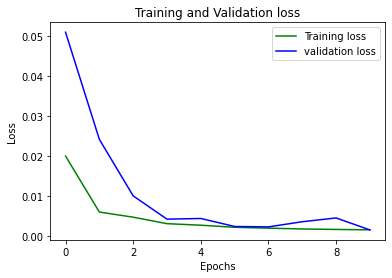

In [163]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,n_epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [164]:
y_pred=model(X_test)

on va rescale les données.

In [165]:
y_pred=scalerY.inverse_transform(y_pred)

In [166]:
colsnames=[]
for i in range(0,100):
    colsnames.append('T-{}'.format(i))

colsnames

['T-0',
 'T-1',
 'T-2',
 'T-3',
 'T-4',
 'T-5',
 'T-6',
 'T-7',
 'T-8',
 'T-9',
 'T-10',
 'T-11',
 'T-12',
 'T-13',
 'T-14',
 'T-15',
 'T-16',
 'T-17',
 'T-18',
 'T-19',
 'T-20',
 'T-21',
 'T-22',
 'T-23',
 'T-24',
 'T-25',
 'T-26',
 'T-27',
 'T-28',
 'T-29',
 'T-30',
 'T-31',
 'T-32',
 'T-33',
 'T-34',
 'T-35',
 'T-36',
 'T-37',
 'T-38',
 'T-39',
 'T-40',
 'T-41',
 'T-42',
 'T-43',
 'T-44',
 'T-45',
 'T-46',
 'T-47',
 'T-48',
 'T-49',
 'T-50',
 'T-51',
 'T-52',
 'T-53',
 'T-54',
 'T-55',
 'T-56',
 'T-57',
 'T-58',
 'T-59',
 'T-60',
 'T-61',
 'T-62',
 'T-63',
 'T-64',
 'T-65',
 'T-66',
 'T-67',
 'T-68',
 'T-69',
 'T-70',
 'T-71',
 'T-72',
 'T-73',
 'T-74',
 'T-75',
 'T-76',
 'T-77',
 'T-78',
 'T-79',
 'T-80',
 'T-81',
 'T-82',
 'T-83',
 'T-84',
 'T-85',
 'T-86',
 'T-87',
 'T-88',
 'T-89',
 'T-90',
 'T-91',
 'T-92',
 'T-93',
 'T-94',
 'T-95',
 'T-96',
 'T-97',
 'T-98',
 'T-99']

In [167]:
y_pred=pd.DataFrame(y_pred)
y_pred.head()

,0,1,2,3,4,5,6,7,8,9
0,434.925093,443.864233,444.863294,444.335878,438.592117,446.372976,441.505549,439.338349,438.344422,436.341201
1,437.976550,441.857307,442.872295,437.575736,435.915825,444.609411,443.231957,437.097241,442.135684,438.355691
2,426.040415,436.098350,431.509590,431.906256,427.918003,435.965136,432.952843,431.045373,432.054564,431.860328
3,426.380750,425.172682,428.763826,423.404085,422.755780,427.985536,431.608586,426.708337,431.918308,428.742749
4,422.977128,426.353451,426.598869,427.166043,424.586606,426.982515,428.461822,424.897772,427.847580,428.237975


In [168]:
X_test=tf.reshape(X_test,shape=(X_test.shape[0],X_test.shape[1]))
X_test=pd.DataFrame(X_test)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.374684,0.373413,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,...,0.132355,0.130952,0.134038,0.144663,0.146741,0.148161,0.149055,0.142848,0.146662,0.140788
1,0.373413,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,...,0.130952,0.134038,0.144663,0.146741,0.148161,0.149055,0.142848,0.146662,0.140788,0.143208
2,0.373159,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,...,0.134038,0.144663,0.146741,0.148161,0.149055,0.142848,0.146662,0.140788,0.143208,0.133687
3,0.395820,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,0.346290,...,0.144663,0.146741,0.148161,0.149055,0.142848,0.146662,0.140788,0.143208,0.133687,0.134363
4,0.385002,0.383407,0.390183,0.382793,0.354706,0.345466,0.347088,0.334526,0.346290,0.338409,...,0.146741,0.148161,0.149055,0.142848,0.146662,0.140788,0.143208,0.133687,0.134363,0.134021


ligne par ligne on va mettre bout à bout (X_test,y_pred) et comparer avec (X_test,y_test)

In [169]:
X_test=scalerX.inverse_transform(X_test)

In [170]:
X_test=pd.DataFrame(X_test)
predictions=pd.concat([X_test,y_pred], axis=1, ignore_index=True)

In [171]:
y_test=tf.reshape(y_test,shape=(y_test.shape[0],y_test.shape[1]))
y_test=scalerY.inverse_transform(y_test)
y_test=pd.DataFrame(y_test)
y_test.head()

,0,1,2,3,4,5,6,7,8,9
0,441.34,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37
1,430.48,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18
2,431.25,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55
3,430.86,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,435.72
4,433.99,427.36,430.34,434.70,432.81,431.37,418.18,433.55,435.72,447.93


In [172]:
test=pd.concat([X_test,y_test], axis=1, ignore_index=True)
#test=pd.DataFrame(test, columns=colsnames)

Est ce que toutes les matrices de données séquentielles sont symétriques?

In [173]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,705.39,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,...,434.925093,443.864233,444.863294,444.335878,438.592117,446.372976,441.505549,439.338349,438.344422,436.341201
1,703.94,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,...,437.976550,441.857307,442.872295,437.575736,435.915825,444.609411,443.231957,437.097241,442.135684,438.355691
2,703.65,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,...,426.040415,436.098350,431.509590,431.906256,427.918003,435.965136,432.952843,431.045373,432.054564,431.860328
3,729.50,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,...,426.380750,425.172682,428.763826,423.404085,422.755780,427.985536,431.608586,426.708337,431.918308,428.742749
4,717.16,715.34,723.07,714.64,682.60,672.06,673.91,659.58,673.00,664.01,...,422.977128,426.353451,426.598869,427.166043,424.586606,426.982515,428.461822,424.897772,427.847580,428.237975


In [174]:
predictions[99:100][0]

99    431.37
Name: 0, dtype: float64

In [175]:
def truc_que_je_vais_plot(predictions, num_col):
    a=[]
    for i in range(0,100):
        a.append(predictions[i][num_col])
    return a

In [176]:
result_pred=truc_que_je_vais_plot(predictions,90)
result_test=truc_que_je_vais_plot(test, 90)

Note : ce n'est pas le result_test exact car le scaler a été sur des données qui peuvent avoir changé d'échelle depuis.

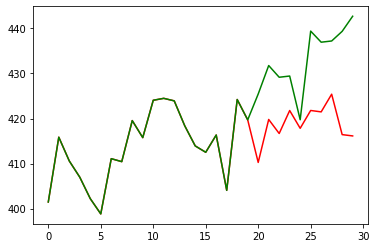

In [177]:
plt.plot(result_pred[70:100], color='r')
plt.plot(result_test[70:100], color='g')
plt.show()

Ouais pour la ligne 10 on voit vraiment bien l'opposition de phase.

On voit dans plot_2 qu'on est parfois en phase parfois à l'opposé mais plutôt pas mal niveau amplitude, selon un certain axe.

On voit dans premier_plot que le modèle prédit le mouvement mais moins bien l'amplitude. Une sorte de biais?

Pour moi un indicateur de performance stylé est le suivant : à quelle fréquence le modèle prédit une hausse à juste titre?

In [178]:
def ma_loss(y_pred,y_test):
    score=0
    scores=[]
    for i in range(0, y_pred.shape[0]):#parcours de toutes nos séquences testées.
        move_pred=''#le move qu'on prédit
        if y_pred[99][i]-y_pred[98][i]>0:
            move_pred='UP'
        else:
            move_pred='DOWN'

        move_truth=''#ce qu'il s'est vraiment passé
        if y_test[99][i]-y_test[98][i]>0:
            move_truth='UP'
        else:
            move_truth='DOWN'

        if move_truth==move_pred:
            score+=1
            scores.append((score)/(i+1))
        else:
            scores.append((score)/(i+1))
        
    return scores      

va permettre de voir si on perd en qualité au fur et à mesure qu'on s'éloigne de l'ordre des données qui ont réalisé l'entrainement.

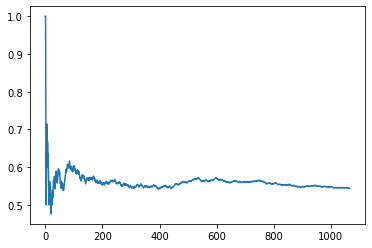

In [179]:
truc=ma_loss(test,predictions)
plt.plot(truc)

ça commence à décroitre autour de 120 jours. ->ré entrainer?

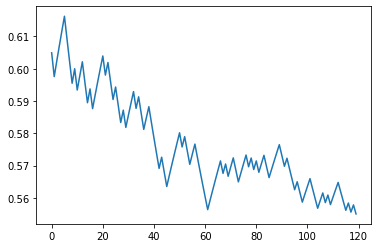

In [180]:
plt.plot(truc[80:200])

s'adapter de sorte à bet que lorsque l'algo est à peak performance?

random thoughts :

- à ce stade tout ce qu'on a c'est un algo qui prédit le mouvement du marché jusqu'à 9% mieux que le hasard.

- il faudrait qu'on essaye d'avoir un truc qui se déclenche quand une action est prise. Parce qu'il n'y a que la qu'on perd ou gagne vraiment.